## Capital Asset Pricing Model

이번 시간에는 CAPM 모형에 대해서 실습을 진행합니다

### 1. Data Import

yfinance 혹은 pandas datareader를 통해 주가 데이터를 불러온다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web

data = pd.DataFrame()
for code in ['005930', '000660', '035720', '035420'] :
    data = pd.concat([data, web.DataReader(code, 'naver', start = '2023-01-01', end = '2023-08-01')['Close'].apply(int)], axis = 1)

data.columns = ['Samsung', 'Hynics', 'Kakao', 'Naver']
noa = len(data.columns)
data

,Samsung,Hynics,Kakao,Naver
2023-01-02,55500,75700,52700,179500
2023-01-03,55400,75600,53300,178500
2023-01-04,57800,81000,55700,182500
2023-01-05,58200,81400,57700,186000
2023-01-06,59000,83100,57200,185000
...,...,...,...,...
2023-07-26,69800,113000,47800,197700
2023-07-27,71700,124000,50600,211500
2023-07-28,70600,128000,50600,211000
2023-07-31,69800,123400,51300,227000


<AxesSubplot:>

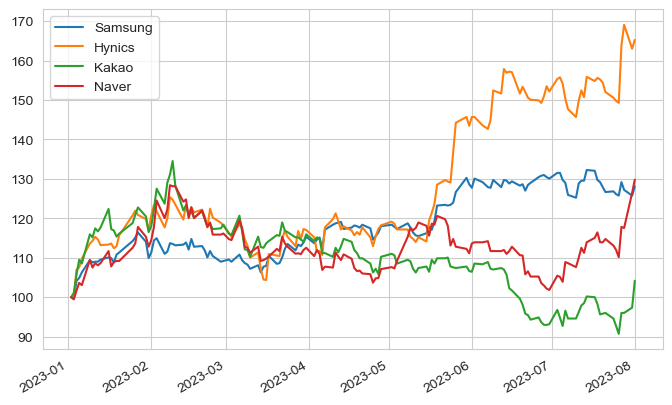

In [2]:
# Normalized Plot
(data / data.iloc[0] * 100).plot(figsize=(8, 5))

model 분석을 위해 수익률을 계산해 준다

In [3]:
ret = (np.log(data) - np.log(data.shift())).dropna()
ret

,Samsung,Hynics,Kakao,Naver
2023-01-03,-0.001803,-0.001322,0.011321,-0.005587
2023-01-04,0.042409,0.068993,0.044044,0.022162
2023-01-05,0.006897,0.004926,0.035277,0.018997
2023-01-06,0.013652,0.020669,-0.008703,-0.005391
2023-01-09,0.028406,0.034303,0.065958,0.060307
...,...,...,...,...
2023-07-26,-0.002861,-0.003534,-0.021729,-0.016554
2023-07-27,0.026857,0.092894,0.056926,0.067474
2023-07-28,-0.015461,0.031749,0.000000,-0.002367
2023-07-31,-0.011396,-0.036599,0.013739,0.073092


### 2. Random Portfolio

가중치 계산을 위해 random portfolio를 계산한다

In [4]:
weights = np.random.random(noa)
weights /= sum(weights)

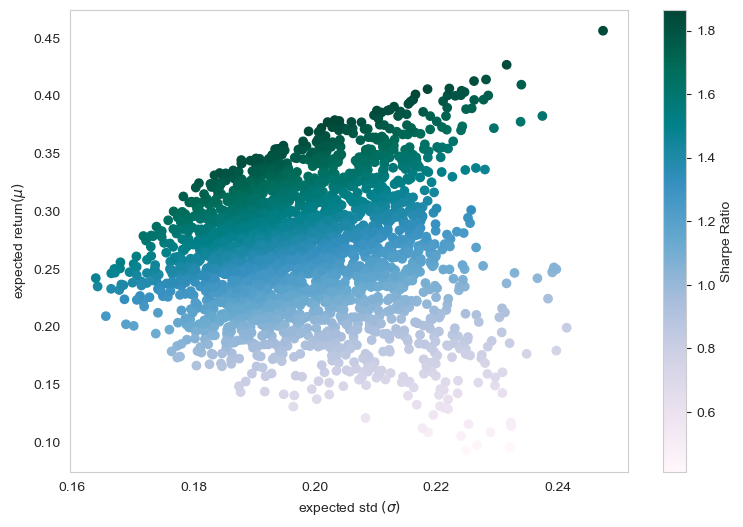

In [5]:
port_rets = []
port_std = []

def ret_std(weight, ret):
    port_mean = np.sum(weight * ret.mean() * 144) # sample mean
    port_var = np.dot(weight.T, np.dot(ret.cov() * 144, weight)) # sample variance
    port_std = np.sqrt(port_var) # sample standard deviation
    return port_mean, port_std

for w in range(2500):
    weight = np.random.random(noa)
    weight /= np.sum(weight)
    mu, sig = ret_std(weight, ret)
    port_rets.append(mu)
    port_std.append(sig)

sr = np.array(port_rets)/np.array(port_std) # sharpe ratio

plt.figure(figsize = (9,6))
plt.scatter(port_std, port_rets, c = sr, marker = 'o',  cmap = 'PuBuGn')
plt.colorbar(label = 'Sharpe Ratio')
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$');
plt.grid()

#### 3. Optimization 1: weights maximizing the Sharpe ratio
$$\max_{w_i's} (\mathrm{Sharpe ~ Ratio})\equiv \frac{r_p-r_f}{\sigma_p} ~~~~ \mbox{such that }  ~~~~ \sum_{i=1}^N w_i =1 , 0 \le w_i \le 1$$

In [6]:
import scipy.optimize as opt

def statistics(weights, rf = 0, period = 246):
    weights = np.array(weights)
    pret = np.sum(ret.mean() * weights) * period - rf
    pvol = np.sqrt(np.dot(weights.T, np.dot(ret.cov() * period, weights)))
    return np.array([pret, pvol, pret / pvol])

def min_func_sharpe(weights, rf = 0):
    return -statistics(weights, rf = rf, period = 144)[2]

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method = 'SLSQP',
                    bounds = bnds, constraints = cons)

opts

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.8755822831340683
       x: [ 2.443e-01  6.345e-01  0.000e+00  1.212e-01]
     nit: 7
     jac: [ 6.390e-05  5.764e-05  1.026e+00 -4.306e-04]
    nfev: 35
    njev: 7

In [7]:
opts.x.round(3)

array([0.244, 0.634, 0.   , 0.121])

#### 4. Optimization 2: weights minimizing variance (volatility)

$$\max_{w_i's} \sigma_p^2 ~~~~ \mbox{such that }  ~~~~ \sum_{i=1}^N w_i =1 , 0 \le w_i \le 1$$

In [10]:
def min_func_volatility(weights):
    return statistics(weights)[1] ** 2

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
optv = opt.minimize(min_func_volatility, noa * [1. / noa,], method = 'SLSQP',
                    bounds = bnds, constraints = cons)

In [11]:
optv.x.round(3)

array([0.852, 0.   , 0.006, 0.141])

####